In [6]:
from moviepy import VideoFileClip
import os

In [7]:
import sys
print(sys.executable)

/home/adi_6200_/mmr/.venv/bin/python


In [8]:
!uv pip list | grep -i moviepy

Using Python 3.12.3 environment at: /home/adi_6200_/mmr/.venv
moviepy                  2.2.1


In [4]:
def extract_audio(video_path: str, output_dir: str = "../data/raw/", output_ext='.wav'):
    """
    Extracts audio from the video and saves it as a WAV file. 
    """
    # create the output directory if it does not exist
    os.makedirs(output_dir, exist_ok=True)
    
    # generate the file name
    filename = os.path.basename(video_path).split('.')[0]
    output_path = os.path.join(output_dir, f'{filename}{output_ext}')
    
    if os.path.exists(output_path):
        print(f"Audio already exists at : {output_path}")
        return output_path
    
    try:
        video_clip = VideoFileClip(video_path)
        
        if video_clip.audio is None:
            print("Error: This video has no sound")
            return None
        
        video_clip.audio.write_audiofile(output_path, logger='bar')
        video_clip.close()
        return output_path
    except Exception as e:
        print(f"Error: {e}")
        return None

In [7]:
path = extract_audio(video_path="../data/raw/Interview_1.mp4")

MoviePy - Writing audio in ../data/raw/Interview_1.wav


MoviePy - Done.


## Feature Engineering for Audio Data

In [1]:
import librosa
import numpy as np
import pandas as pd
import os

In [8]:
y, sr = librosa.load("../data/raw/Interview_1.wav", sr=None)

In [ ]:
type(y)

numpy.ndarray

In [ ]:
y.shape

(15259922,)

In [11]:
sr

44100

In [14]:
y.shape[0]/(sr*60) # this should give the duration of the visdeo

5.767166288737718

In [15]:
def analyze_audio_layers(audio_path: str, segment_length: float=0.5) -> pd.DataFrame:
    """
    Input: 
        audio_path: path to the audio file
        segment_length: time window in secs (same as video dataframe)
    Output:
        au_data: dataframe with TS features for analysis (Ready to go to the data analysis pipeline)
    """
    # check is the audio file exists
    if not os.path.exists(audio_path):
        print(f"Error: {audio_path} does not exit")
        return None
    
    # loading audio file
    y, sr = librosa.load(audio_path, sr=None)
    
    # total duration
    total_duration = librosa.get_duration(y=y, sr=sr)
    
    au_data = []
    
    # iterating through the audio chunks
    for t in np.arange(0, total_duration, segment_length):
        
        # calculating the starting and ending indexes for this chunk
        start_sample = int(t * sr)
        end_sample = int((t + segment_length)*sr)
        
        # getting the chunk for this iteration
        chunk = y[start_sample:end_sample]
        
        # check if the file ended
        if len(chunk) == 0: break
        
        # FEATURE - 1: AMPLITUDE (Confidence/Volume)
        rms = np.mean(librosa.feature.rms(y=chunk))
        
        # FEATURE - 2: SILENCE DETECTION
        # Threshold: 0.005 is a standard "noise floor" for webcams
        is_silent = rms < 0.005
        
        # FEATURE 3 & 4: PITCH TRACKING (Monotone vs Expressive)
        avg_pitch = 0
        pitch_var = 0
        
        # if not silent
        if not is_silent:
            f0, voiced_flag, _ = librosa.pyin(
                chunk,
                fmin=librosa.note_to_hz('C2'),
                fmax=librosa.note_to_hz('C5'),
                sr=sr,
                frame_length=2048
            )
            
            # filtering out the NaNs (moments of unvoiced sound)
            valid_pitch = f0[~np.isnan(f0)]
            
            if len(valid_pitch) > 0:
                avg_pitch = np.mean(valid_pitch)
                # I think this is super cool this pitch var effectively measures you expressiveness
                pitch_var = np.std(valid_pitch) 
                
        # creating the row
        au_data.append({
            "Time": round(t, 2),
            "audio_rms(volumn)": round(rms, 4),
            "audio_pitch_avg": round(avg_pitch, 2),
            "audio_pitch_var(expressiveness)": round(pitch_var, 2),
            "is_silent": is_silent
        })
        
    # converting into a dataframe
    au_data = pd.DataFrame(au_data)
    au_data = au_data.sort_values('Time').reset_index(drop=True)
    
    return au_data
                  

In [16]:
df = analyze_audio_layers(audio_path="../data/raw/Interview_1.wav")

In [17]:
df.head()

,Time,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent
0,0.0,0.0000,0.00,0.00,True
1,0.5,0.0000,0.00,0.00,True
2,1.0,0.0000,0.00,0.00,True
3,1.5,0.0020,0.00,0.00,True
4,2.0,0.0141,150.88,3.73,False


In [19]:
df.tail()

,Time,audio_rms(volumn),audio_pitch_avg,audio_pitch_var(expressiveness),is_silent
688,344.0,0.0026,0.0,0.0,True
689,344.5,0.0000,0.0,0.0,True
690,345.0,0.0000,0.0,0.0,True
691,345.5,0.0000,0.0,0.0,True
692,346.0,0.0000,0.0,0.0,True


In [29]:
import os
import sys

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print("Added project root to the system path")


Added project root to the system path


In [24]:
os.getcwd()

'/home/adi_6200_/mmr/notebooks'

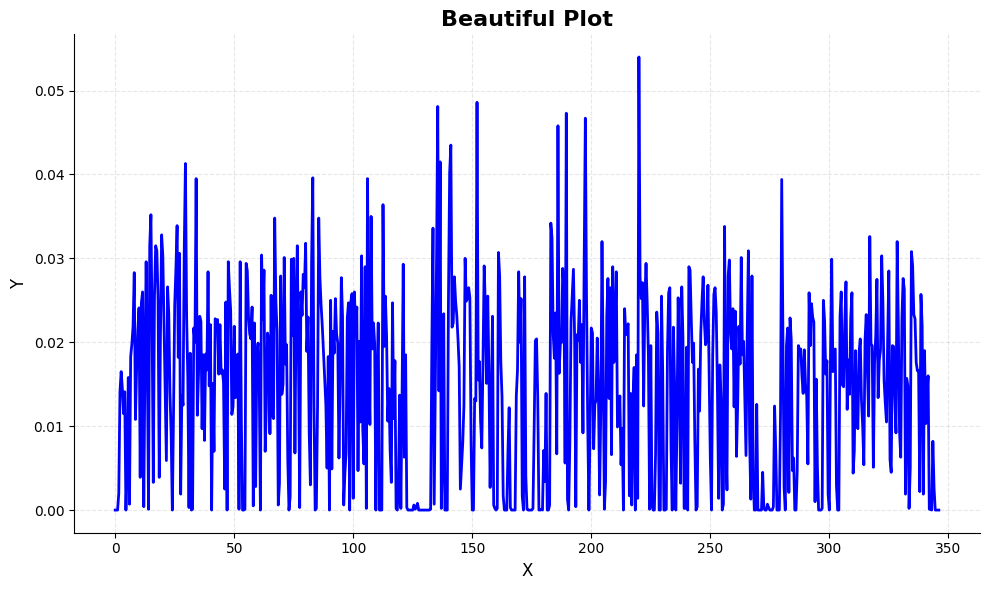

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Beautiful Plot'}, xlabel='X', ylabel='Y'>)

In [30]:
from src.utils.plot_graphs import plot_beautiful

plot_beautiful(x=df['Time'], y=df['audio_rms(volumn)'])

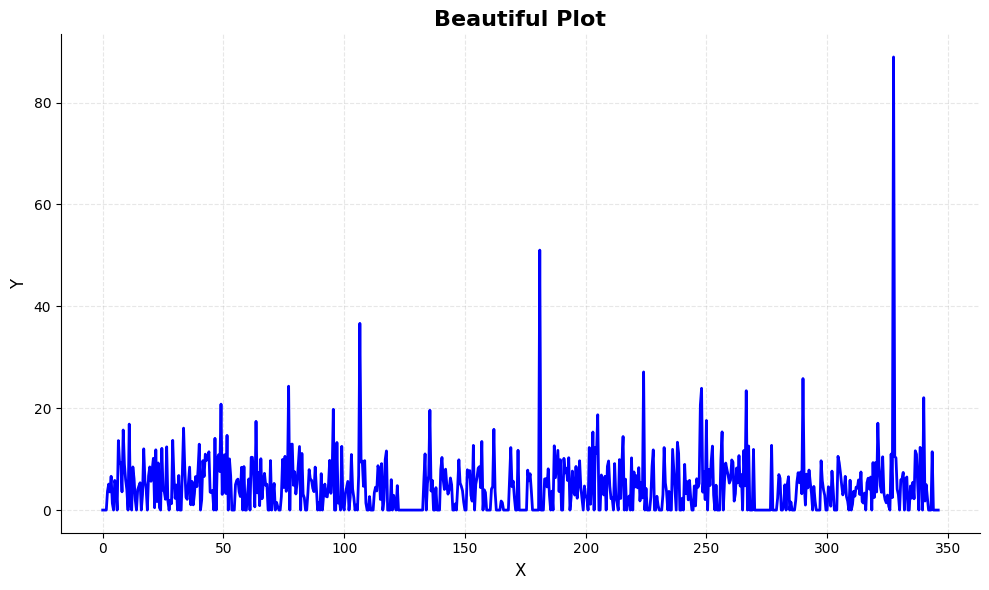

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Beautiful Plot'}, xlabel='X', ylabel='Y'>)

In [31]:
plot_beautiful(x=df['Time'], y=df['audio_pitch_var(expressiveness)'])

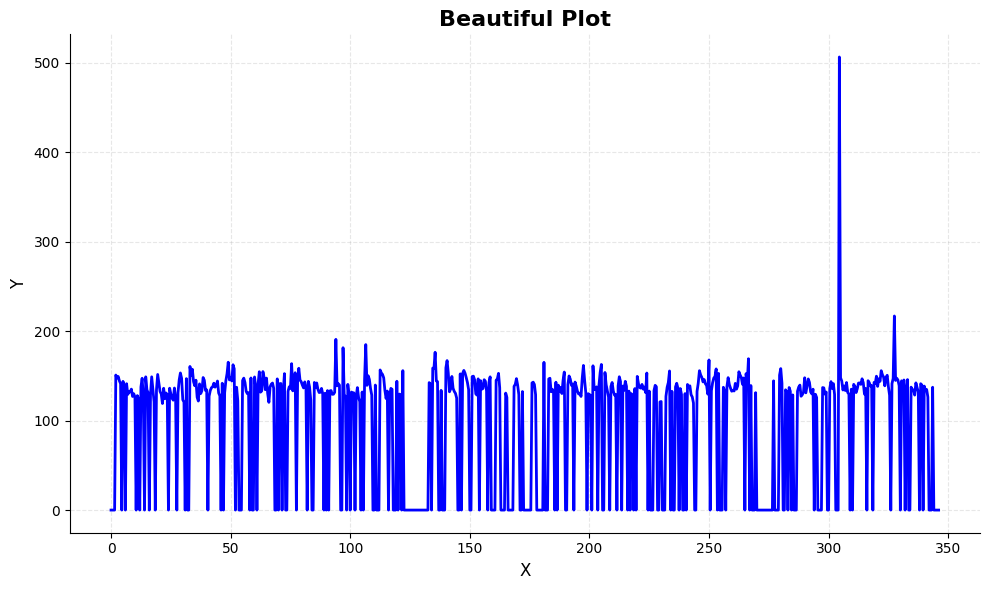

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Beautiful Plot'}, xlabel='X', ylabel='Y'>)

In [32]:
plot_beautiful(x=df['Time'], y=df['audio_pitch_avg'])